In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [3]:
# STEP 1 :- Specify date range analysis
start = dt.datetime(2014,1,1)
end = dt.datetime(2018,1,1)
start,end

(datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0))

In [4]:
# Select stocks you would like to analyse
stocklist = ['GOOG']
stocks = stocklist

In [5]:
# STEP 2 :- Call the pandas_DataReader Datareader module:

# 2 ways of doing this:

# 1.   pdr.DataReader(stocks,'yahoo',start,end)
# 2.   pdr.get_data_yahoo(stocks,start,end)

goog_data=pdr.get_data_yahoo('GOOG',start,end)
goog_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,27.782366,27.839401,27.603037,27.724083,27.724083,73129082
2014-01-03,27.770908,27.818977,27.520098,27.521841,27.521841,66917888
2014-01-06,27.721344,27.867046,27.557707,27.828691,27.828691,71037271
2014-01-07,28.019974,28.385853,27.924334,28.365179,28.365179,102486711
2014-01-08,28.543015,28.575891,28.226450,28.424210,28.424210,90036218


In [6]:
# STEP 3 :- To serialize an object file, hence pickle it.
SRC_DATA_FILENAME = 'goog_data.pkl'
# goog_data = pd.read_pickle(SRC_DATA_FILENAME)
goog_data=pdr.get_data_yahoo('GOOG',start,end)
goog_data.to_pickle(SRC_DATA_FILENAME)

[*********************100%***********************]  1 of 1 completed


In [9]:
# STEP 4 :- Preparing the data

goog_data_signal = pd.DataFrame(index = goog_data.index)
goog_data_signal['price'] = goog_data['Adj Close']
goog_data_signal['daily_difference'] = goog_data_signal['price'].diff()
goog_data_signal['signal'] = 0.0
goog_data_signal['signal'] = np.where(goog_data_signal['daily_difference'] > 0,1,0)
print(goog_data_signal)



                price  daily_difference  signal
Date                                           
2014-01-02  27.724083               NaN       0
2014-01-03  27.521841         -0.202242       0
2014-01-06  27.828691          0.306850       1
2014-01-07  28.365179          0.536488       1
2014-01-08  28.424210          0.059031       1
...               ...               ...     ...
2017-12-22  53.006001         -0.175499       0
2017-12-26  52.837002         -0.168999       0
2017-12-27  52.468498         -0.368504       0
2017-12-28  52.407001         -0.061497       0
2017-12-29  52.320000         -0.087002       0

[1007 rows x 3 columns]


In [10]:
# Creating a trading_support_resistance function

def trading_support_resistance(data,bin_width=50) :
    
#     creating variables
    data['sup_tolerance']= pd.Series(np.zeros(len(data)))
    data['res_tolerance']= pd.Series(np.zeros(len(data)))
    data['sup_count']= pd.Series(np.zeros(len(data)))
    data['res_count']= pd.Series(np.zeros(len(data)))
    
    data['sup']= pd.Series(np.zeros(len(data)))
    data['res']= pd.Series(np.zeros(len(data)))
    data['positions']= pd.Series(np.zeros(len(data)))
    data['signals']= pd.Series(np.zeros(len(data)))
    
    in_support = 0
    in_resistance =0
    
#     Defining & assigning value to newly created variables
    for x in range((bin_width-1) + bin_width, len(data)):
        data_section = data[x - bin_width : x+1]
        support_level = min (data_section['price'])
        resistance_level = max (data_section['price'])
        range_level = resistance_level - support_level
    
#    Assigning new variables as values to old variables
        data['res'][x] = resistance_level
        data['sup'][x] = support_level
        data['sup_tolerance'][x] = support_level + 0.2*range_level
        data['res_tolerance'][x] = resistance_level - 0.2*range_level
    
#     Command for action
        if data['price'][x] >= data['res_tolerance'][x] and data['price'][x]<= data['res'][x]:
            in_resistance += 1
            data['res_count'][x] = in_resistance
        
        elif data['price'][x] <= data['sup_tolerance'][x] and data['price'][x] >= data['sup'][x]:
            in_support += 1
            data['sup_count'][x] = in_support
        
        else :
            in_support = 0
            in_resistance = 0
            
            
        if in_resistance >2 :
                data['signal'][x] = 1
                
        elif in_support > 2 :
            data['signal'][x] = 0
            
        else :
            data['signal'][x] = data['signal'][x-1]
            
    data['positions'] = data['signal'].diff()
                    
trading_support_resistance(goog_data_signal)
    

/var/folders/f0/w75fn189363555xwnt7mv5640000gn/T/ipykernel_752/3700822417.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['res'][x] = resistance_level
/var/folders/f0/w75fn189363555xwnt7mv5640000gn/T/ipykernel_752/3700822417.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sup'][x] = support_level
/var/folders/f0/w75fn189363555xwnt7mv5640000gn/T/ipykernel_752/3700822417.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

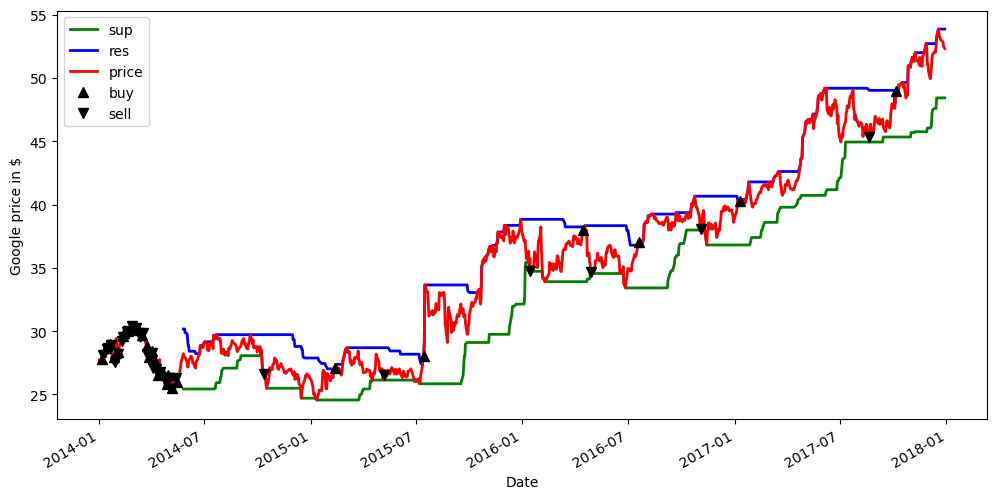

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(111, ylabel ='Google price in $')
goog_data_signal['sup'].plot(ax=ax1, color = 'g', lw =2.)
goog_data_signal['res'].plot(ax=ax1, color = 'b', lw =2.)
goog_data_signal['price'].plot(ax=ax1, color = 'r', lw =2.)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index,goog_data_signal.price[goog_data_signal.positions==1.0],'^',markersize=7,color='k',label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index,goog_data_signal.price[goog_data_signal.positions== -1.0],'v',markersize=7,color='k',label='sell')
plt.legend()
plt.show()

In [12]:
goog_data.head()
close = goog_data['Close']
print(close)

Date
2014-01-02    27.724083
2014-01-03    27.521841
2014-01-06    27.828691
2014-01-07    28.365179
2014-01-08    28.424210
                ...    
2017-12-22    53.006001
2017-12-26    52.837002
2017-12-27    52.468498
2017-12-28    52.407001
2017-12-29    52.320000
Name: Close, Length: 1007, dtype: float64


In [13]:
# Implementation of SMA over a 20 day moving window

import statistics as stats
time_period = 20
history = []
sma_values = []

for close_price in close :
    history.append(close_price)
# we remove oldest price because we only average over last 'time_period' prices
    if len (history) > time_period : 
        del(history[0])
    sma_values.append(stats.mean(history))
    
goog_data = goog_data.assign(ClosePrice = pd.Series(close,index = goog_data.index))
goog_data = goog_data.assign(Simple20DayMovingAverage = pd.Series(sma_values,index = goog_data.index))
close_price = goog_data['ClosePrice']
sma = goog_data['Simple20DayMovingAverage']


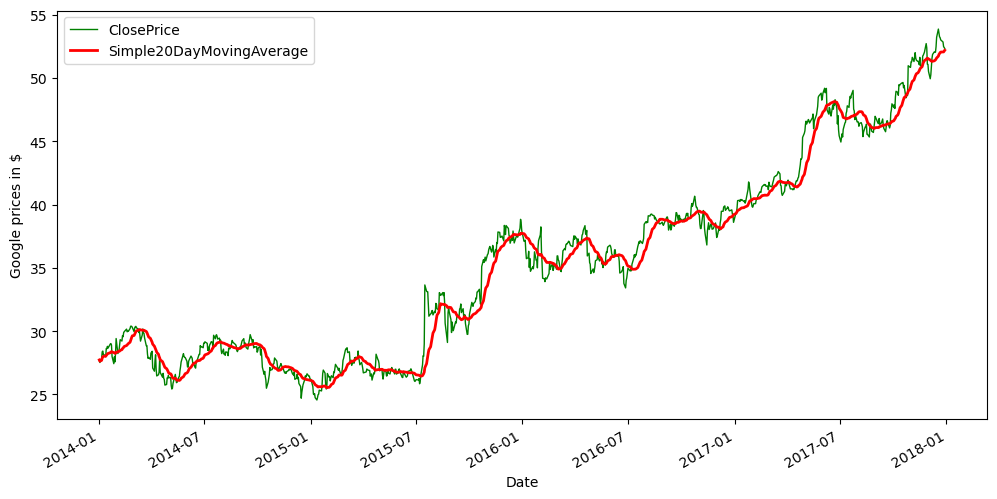

In [14]:
# Visual representation of SMA over a 20 day moving window

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111,ylabel = 'Google prices in $')
close_price.plot(ax=ax1, color='g',lw=1.,legend = True)
sma.plot(ax=ax1, color='r',lw=2.,legend = True)
plt.show()

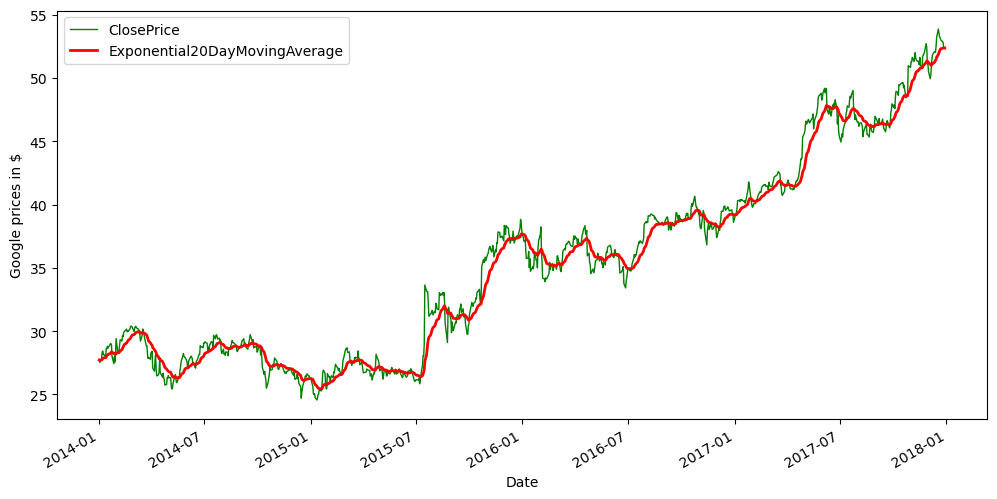

In [15]:
# Implementation of EMA over a 20 day moving window

import statistics as stats
num_periods = 20

# smoothing constant
K = 2/(num_periods + 1)
ema_p = 0
ema_values = []

for close_price in close :
# First observation, EMA = current_price
    if (ema_p == 0): 
        ema_p = close_price
    else :
        ema_p = (close_price - ema_p) * K + ema_p
    ema_values.append(ema_p)
    
goog_data = goog_data.assign(ClosePrice = pd.Series(close,index = goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverage = pd.Series(ema_values,index = goog_data.index))
close_price = goog_data['ClosePrice']
ema = goog_data['Exponential20DayMovingAverage']

# Visual representation of SMA over a 20 day moving window

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111,ylabel = 'Google prices in $')
close_price.plot(ax=ax1, color='g',lw=1.,legend = True)
ema.plot(ax=ax1, color='r',lw=2.,legend = True)
plt.savefig('ema.png')
plt.show()

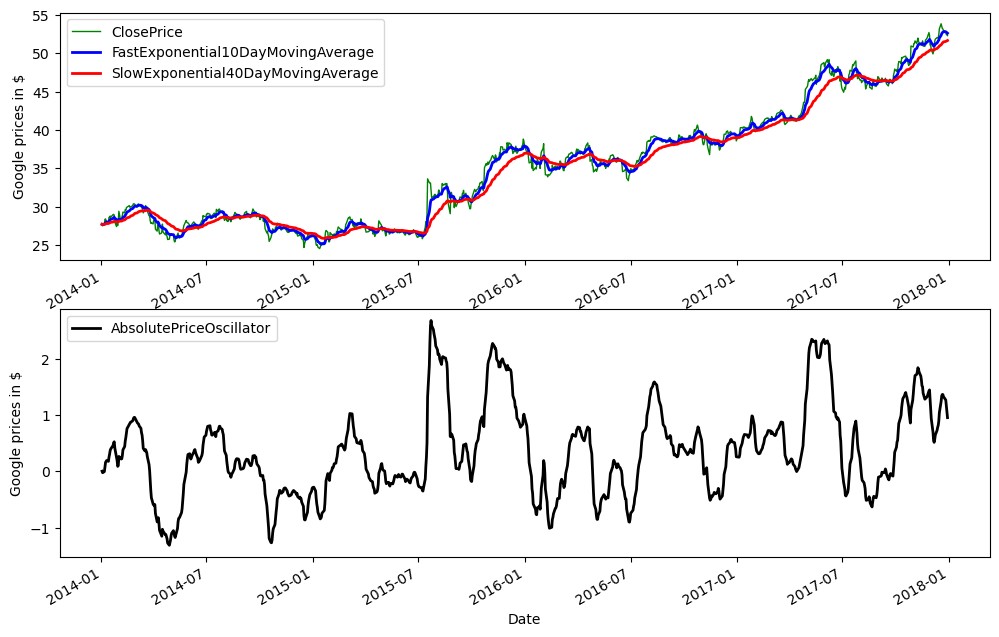

In [16]:
# Implementation of Absolute Pice Oscillator over a 10 & 40 days moving window with 2/(n+1) smoothing constant

num_periods_fast = 10
# smoothing constant
K_fast = 2/(num_periods_fast + 1)
ema_fast = 0

num_periods_slow = 40
# smoothing constant
K_slow = 2/(num_periods_slow + 1)
ema_slow = 0


ema_fast_values = []
ema_slow_values = []
apo_values = []


for close_price in close :
# First observation, EMA = current_price
    if (ema_fast == 0): 
        ema_fast = close_price
        ema_slow = close_price
    else :
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow
        
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    apo_values.append(ema_fast - ema_slow)
    
goog_data = goog_data.assign(ClosePrice = pd.Series(close,index = goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage = pd.Series(ema_fast_values,index = goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage = pd.Series(ema_slow_values,index = goog_data.index))
goog_data = goog_data.assign(AbsolutePriceOscillator = pd.Series(apo_values,index = goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
apo = goog_data['AbsolutePriceOscillator']


# Visual representation of APO

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211,ylabel = 'Google prices in $')
close_price.plot(ax=ax1, color='g',lw=1.,legend = True)
ema_f.plot(ax=ax1, color='b',lw=2.,legend = True)
ema_s.plot(ax=ax1, color='r',lw=2.,legend = True)
ax2 = fig.add_subplot(212,ylabel = 'Google prices in $')
apo.plot(ax=ax2, color='black',lw=2.,legend = True)
plt.show()

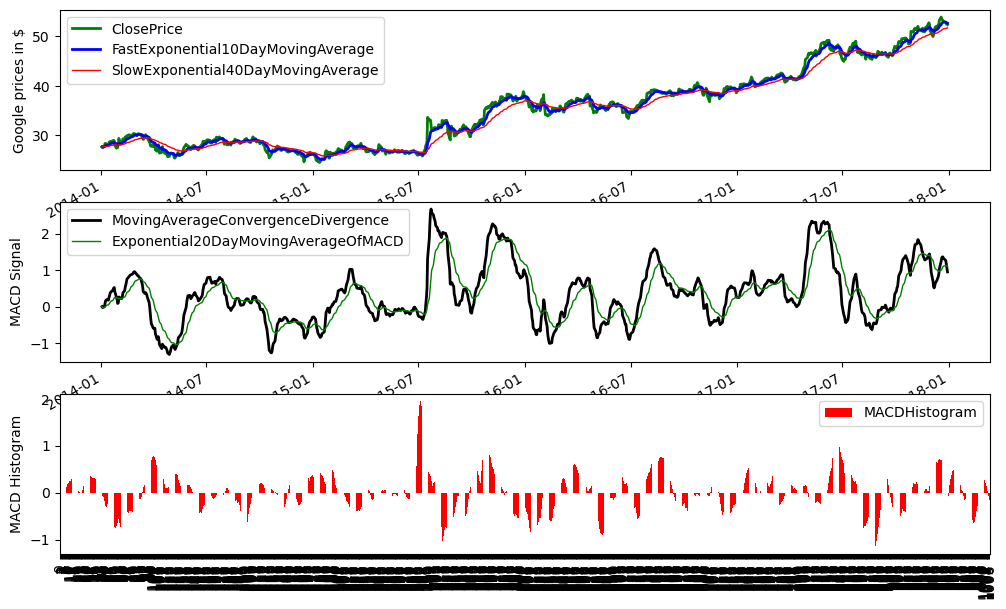

In [17]:
# Implementation of MACD over a 10 & 40 days moving window with 2/(n+1) smoothing constant & 20 days MACD EMA

num_periods_fast = 10
# smoothing constant
K_fast = 2/(num_periods_fast + 1)
ema_fast = 0

num_periods_slow = 40
# smoothing constant
K_slow = 2/(num_periods_slow + 1)
ema_slow = 0

num_periods_macd = 20
# smoothing constant
K_macd = 2/(num_periods_macd + 1)
ema_macd = 0

ema_fast_values = []
ema_slow_values = []
macd_values = []
macd_signal_values = []

# MACD - MACD_ema
macd_histogram_values = []


for close_price in close :
# First observation, EMA = current_price
    if (ema_fast == 0): 
        ema_fast = close_price
        ema_slow = close_price
    else :
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow
        
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    
# MACD is fast_MA - slow_MA
    macd = ema_fast - ema_slow
    if ema_macd == 0: 
        ema_macd = macd
    else :
        ema_macd = (macd - ema_macd) * K_macd + ema_macd
        
    macd_values.append(macd)    
    macd_signal_values.append(ema_macd)
    macd_histogram_values.append(macd - ema_macd)
    
    
goog_data = goog_data.assign(ClosePrice = pd.Series(close,index = goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage = pd.Series(ema_fast_values,index = goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage = pd.Series(ema_slow_values,index = goog_data.index))
goog_data = goog_data.assign(MovingAverageConvergenceDivergence = pd.Series(macd_values,index = goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverageOfMACD = pd.Series(macd_signal_values,index = goog_data.index))
goog_data = goog_data.assign(MACDHistogram = pd.Series(macd_histogram_values,index = goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
macd = goog_data['MovingAverageConvergenceDivergence']
ema_macd = goog_data['Exponential20DayMovingAverageOfMACD']
macd_histogram = goog_data['MACDHistogram']


# Visual representation of EMA, MACD SIGNAL, MACD HISTOGRAM

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))

# FAST EMA vs SLOW EMA
ax1 = fig.add_subplot(311,ylabel = 'Google prices in $')
close_price.plot(ax=ax1, color='g',lw=2.,legend = True)
ema_f.plot(ax=ax1, color='b',lw=2.,legend = True)
ema_s.plot(ax=ax1, color='r',lw=1.,legend = True)

# MACD Signal
ax2 = fig.add_subplot(312,ylabel = 'MACD Signal')
macd.plot(ax=ax2, color='black',lw=2.,legend = True)
ema_macd.plot(ax=ax2, color = 'g',lw = 1., legend = True)

# MACD Histogram
ax3 = fig.add_subplot(313,ylabel = 'MACD Histogram')
macd_histogram.plot(ax=ax3, color='r',kind='bar',legend = True,use_index = False)
plt.show()

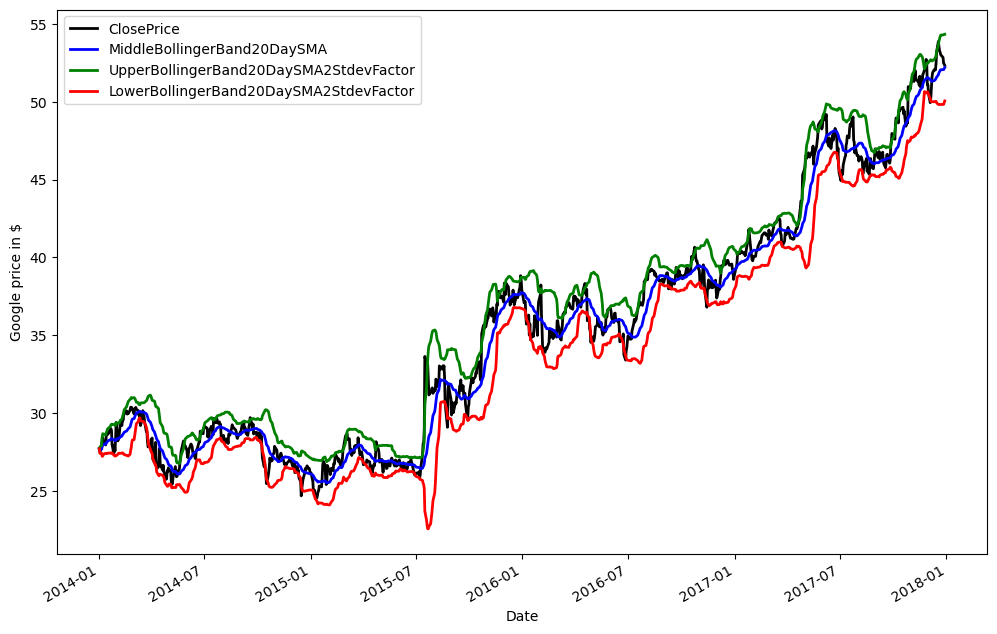

In [21]:
# Implementation of Bollinger Bands

import statistics as stats
import math as math

time_period = 20
stdev_factor = 2

history = []
sma_values = []
upper_band = []
lower_band = []

for close_price in close:
    history.append(close_price)
    if len(history) > time_period:
        del (history[0])
        
    sma = stats.mean(history)
    sma_values.append(sma)
    
    variance = 0
    
    for hist_price in history:
        variance = variance + ((hist_price - sma)**2)
    stdev = math.sqrt(variance/len(history))
    upper_band.append(sma + stdev_factor * stdev)
    lower_band.append(sma - stdev_factor * stdev)
        
        
goog_data = goog_data.assign(ClosePrice = pd.Series(close, index = goog_data.index))
goog_data = goog_data.assign(MiddleBollingerBand20DaySMA = pd.Series(sma_values, index = goog_data.index))
goog_data = goog_data.assign(UpperBollingerBand20DaySMA2StdevFactor = pd.Series(upper_band, index = goog_data.index))
goog_data = goog_data.assign(LowerBollingerBand20DaySMA2StdevFactor = pd.Series(lower_band, index = goog_data.index))

close_price = goog_data['ClosePrice']
mband = goog_data['MiddleBollingerBand20DaySMA']
uband = goog_data['UpperBollingerBand20DaySMA2StdevFactor']
lband = goog_data['LowerBollingerBand20DaySMA2StdevFactor']

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111, ylabel = 'Google price in $')
close_price.plot (ax = ax1, color = 'black', lw = 2., legend = True)
mband.plot(ax = ax1, color = 'b', lw=2., legend = True)
uband.plot(ax = ax1, color = 'g', lw=2., legend = True)
lband.plot(ax = ax1, color = 'r', lw=2., legend = True)
plt.show()


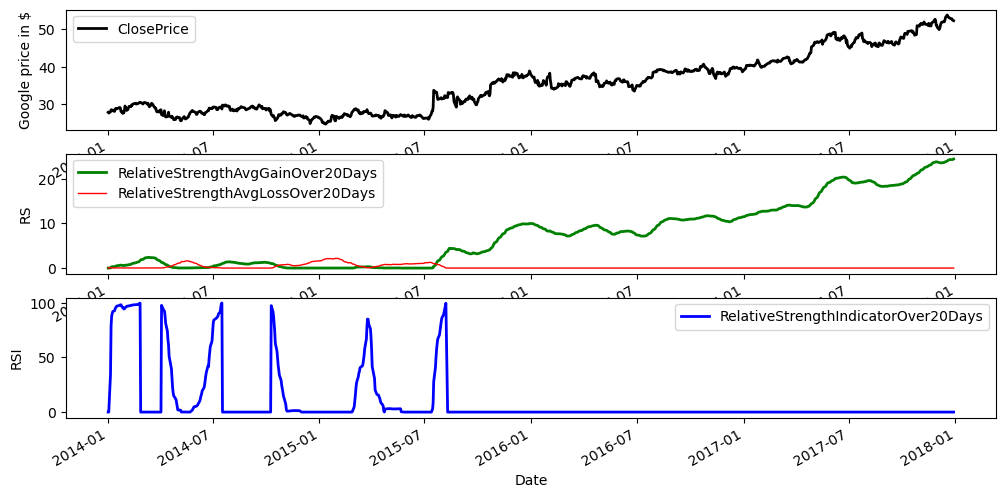

In [30]:
# Implementation of RSI

import statistics as stats

time_period = 20
gain_history = []
loss_history = []
avg_gain_values = []
avg_loss_values = []
rsi_values = []

last_price = 0

for close_price in close:
    if last_price == 0:
        last_price = close_price
        
    gain_history.append(max(0,close_price - last_price))
    loss_history.append(max(0,last_price - close_price))
    
    if len (gain_history) > time_period:
        del (gain_history[0])
        del (loss_history[0])
        
    avg_gain = stats.mean(gain_history)
    avg_loss = stats.mean(loss_history)
    avg_gain_values.append(avg_gain)
    avg_loss_values.append(avg_loss)
    
    rs = 0
    if avg_loss > 0:
        rs = avg_gain/avg_loss
    
    rsi= 100 - (100/(1 + rs))
    rsi_values.append(rsi)
    
goog_data = goog_data.assign(ClosePrice = pd.Series(close,index = goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgGainOver20Days = pd.Series(avg_gain_values,index = goog_data.index))
goog_data = goog_data.assign(RelativeStrengthAvgLossOver20Days = pd.Series(avg_loss_values,index = goog_data.index))
goog_data = goog_data.assign(RelativeStrengthIndicatorOver20Days = pd.Series(rsi_values,index = goog_data.index))

close_price = goog_data['ClosePrice']
rs_gain = goog_data['RelativeStrengthAvgGainOver20Days']
rs_loss = goog_data['RelativeStrengthAvgLossOver20Days']
rsi = goog_data['RelativeStrengthIndicatorOver20Days']

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(311, ylabel = 'Google price in $')
close_price.plot(ax = ax1, color = 'black', lw =2., legend = True)

ax2 = fig.add_subplot(312, ylabel = 'RS')
rs_gain.plot(ax = ax2, color = 'g', lw = 2., legend = True)
rs_loss.plot(ax = ax2, color = 'r', lw =1., legend = True)

ax3 = fig.add_subplot(313, ylabel = 'RSI')
rsi.plot(ax = ax3, color = 'b', lw =2., legend = True)

plt.show()

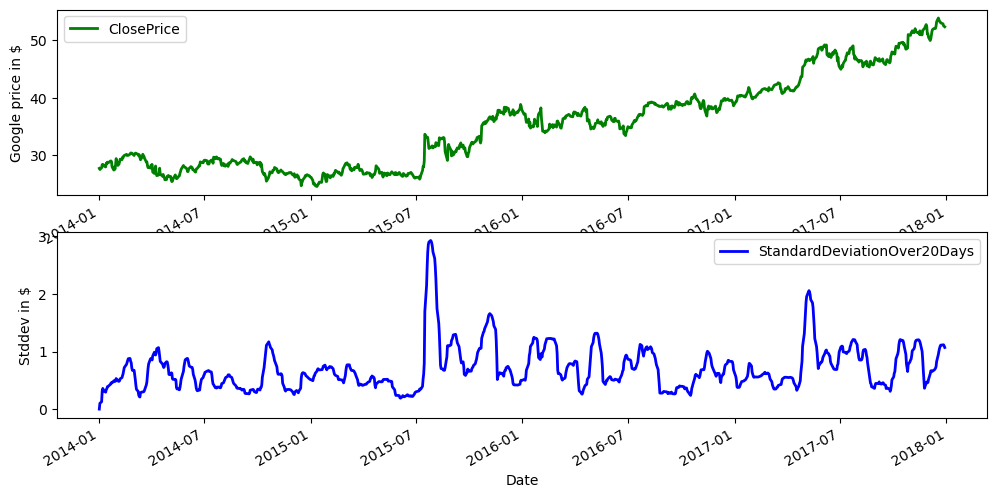

In [34]:
# Implementing standard deviation

import statistics as stats
import math as math

time_period = 20

history = []
sma_values = []
stddev_values = []

for close_price in close:
    history.append(close_price)
    if len(history) > time_period:
        del(history[0])
        
    sma = stats.mean(history)
    sma_values.append(sma)
    
    variance = 0
    for hist_price in history:
        variance = variance + ((hist_price - sma)**2)
        
    stdev = math.sqrt(variance/len(history))
    stddev_values.append(stdev)
    
# visualization part

goog_data = goog_data.assign(ClosePrice = pd.Series(close,index = goog_data.index))
goog_data = goog_data.assign(StandardDeviationOver20Days = pd.Series(stddev_values,index = goog_data.index))

close_price = goog_data['ClosePrice']
stddev = goog_data['StandardDeviationOver20Days']


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(211, ylabel = 'Google price in $')
close_price.plot(ax = ax1, color = 'g', lw = 2., legend = True)

ax2 = fig.add_subplot(212, ylabel = 'Stddev in $')
stddev.plot(ax = ax2, color = 'b', lw = 2., legend = True)

plt.show()


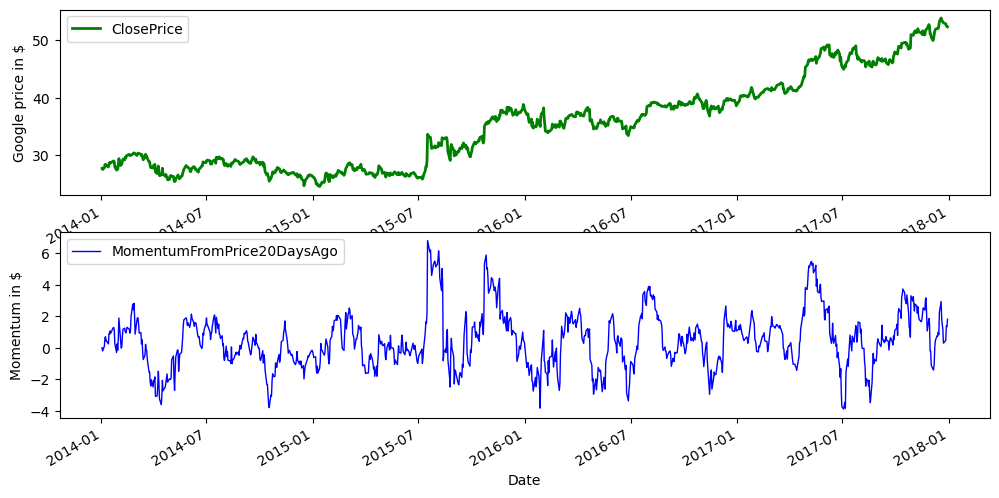

In [38]:
# Implementation of Momentum

time_period = 20
history = []
mom_values = []

for close_price in close:
    history.append(close_price)
    if len(history) > time_period:
        del(history[0])
        
    mom = close_price - history[0]
    mom_values.append(mom)
    
goog_data = goog_data.assign(ClosePrice = pd.Series(close, index = goog_data.index))
goog_data = goog_data.assign(MomentumFromPrice20DaysAgo = pd.Series(mom_values, index = goog_data.index))

close_price = goog_data['ClosePrice']
mom = goog_data['MomentumFromPrice20DaysAgo']

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,6))

ax1 = fig.add_subplot(211, ylabel = 'Google price in $')
close_price.plot(ax= ax1, color = 'g', lw = 2., legend = True)

ax2 = fig.add_subplot(212, ylabel = 'Momentum in $')
mom.plot(ax= ax2, color = 'b', lw = 1., legend = True)
plt.show()

